In [1]:
import numpy as np
import jax.numpy as jnp
from jax import nn, jacfwd, jit, vmap, lax, random
from jax.scipy.stats.norm import cdf, pdf
from functools import partial
import time

# import MCMC library
import numpyro 
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC

class FFNN():

    def __init__(self, n_inputs, n_hidden, n_outputs, 
                 param_0=.2, alpha_0=1.):

        # store dimensions
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs

        # bounds on initial parameter guess
        self.param_0 = param_0
        self.alpha_0 = alpha_0
        
        # determine shapes of weights/biases = [Wih, bih, Who, bho]
        self.shapes = [[n_hidden, n_inputs], [n_hidden], [n_outputs, n_hidden], [n_outputs]]
        self.k_params = []
        self.n_params = 0
        for shape in self.shapes:
            self.k_params.append(self.n_params)
            self.n_params += np.prod(shape)
        self.k_params.append(self.n_params)

        # initialize parameters
        self.params = np.zeros(self.n_params)
        for k1,k2,shape in zip(self.k_params, self.k_params[1:], self.shapes):
            if len(shape)>1:
                stdv = 1/np.sqrt(shape[-1])
            # self.params[k1:k2] = np.random.uniform(-self.param_0, self.param_0, k2-k1)
            self.params[k1:k2] = stdv*np.random.randn(k2-k1)

        # initialize hyper-parameters
        self.a = 1e-4
        self.b = 1e-4
            
        # initialize covariance 
        self.Ainv = None
            
        ### define jit compiled functions ###

        # batch prediction
        self.forward_batch = jit(vmap(self.forward, in_axes=(None, 0)))
        
        # jit compile gradient w.r.t. params
        self.G  = jit(jacfwd(self.forward_batch))
        self.Gi = jit(jacfwd(self.forward))

        # jit compile Newton update direction computation
        def NewtonStep(G, g, alpha, Beta):
            # compute hessian
            A = jnp.diag(alpha) + jnp.einsum('nki,kl,nlj->ij', G, Beta, G)
            # solve for Newton step direction
            d = jnp.linalg.solve(A, g)
            return d
        self.NewtonStep = jit(NewtonStep)

        # jit compile inverse Hessian computation step
        def Ainv_next(G, Ainv, BetaInv):
            GAinv = G@Ainv
            Ainv_step = GAinv.T@jnp.linalg.inv(BetaInv + GAinv@G.T)@GAinv
            Ainv_step = (Ainv_step + Ainv_step.T)/2.
            return Ainv_step
        self.Ainv_next = Ainv_next

        # jit compile measurement covariance computation
        def compute_yCOV(errors, G, Ainv):
            return jnp.einsum('nk,nl->kl', errors, errors) + jnp.einsum('nki,ij,nlj->kl', G, Ainv, G)
        self.compute_yCOV = jit(compute_yCOV)

    # reshape parameters into weight matrices and bias vectors
    def reshape(self, params):
        # params is a vector = [Wih, bih, Who, bho]
        return [np.reshape(params[k1:k2], shape) for k1,k2,shape in zip(self.k_params, self.k_params[1:], self.shapes)]

    # per-sample prediction
    def forward(self, params, sample):
        # reshape params
        Wih, bih, Who, bho = self.reshape(params)
        
        # hidden layer
        h = nn.sigmoid(Wih@sample + bih)

        # output 
        out = Who@h + bho
        
        return out

    # fit to data
    def fit(self, X, Y, lr=1e-2, map_tol=1e-3, evd_tol=1e-3, patience=3, max_fails=3):
        passes = 0
        fails  = 0
        # fit until convergence of evidence
        previdence = -np.inf
        evidence_converged = False
        epoch = 0
        best_evidence_params = np.copy(self.params)
        best_params = np.copy(self.params)

        while not evidence_converged:

            # update hyper-parameters
            self.update_hypers(X, Y)

            # use Newton descent to determine parameters
            prev_loss = np.inf

            # fit until convergence of NLP
            converged = False
            while not converged:
                # forward passs
                outputs = self.forward_batch(self.params, X)
                errors  = np.nan_to_num(outputs - Y)
                residuals = np.sum(errors)/X.shape[0]

                # compute convergence of loss function
                loss = self.compute_loss(errors)
                convergence = (prev_loss - loss) / max([1., loss])
                if epoch%10==0:
                    print("Epoch: {}, Loss: {:.5f}, Residuals: {:.5f}, Convergence: {:5f}".format(epoch, loss, residuals, convergence))

                # stop if less than tol
                if abs(convergence) <= map_tol:
                    # set converged to true to break from loop
                    converged = True
                else:
                    # lower learning rate if convergence is negative
                    if convergence < 0:
                        lr /= 2.
                        # re-try with the smaller step
                        self.params = best_params - lr*d
                    else:
                        # update best params
                        best_params = np.copy(self.params)

                        # update previous loss
                        prev_loss = loss

                        # compute gradients
                        G = self.G(self.params, X)
                        g = np.einsum('nk,kl,nli->i', errors, self.Beta, G) + self.alpha*self.params

                        # determine Newton update direction
                        d = self.NewtonStep(G, g, self.alpha, self.Beta)

                        # update parameters
                        self.params -= lr*d

                        # update epoch counter
                        epoch += 1

            # Update Hessian estimation
            G = self.G(self.params, X)
            self.A, self.Ainv = self.compute_precision(G)

            # compute evidence
            evidence = self.compute_evidence(X, loss)

            # determine whether evidence is converged
            evidence_convergence = (evidence - previdence) / max([1., abs(evidence)])
            print("\nEpoch: {}, Evidence: {:.5f}, Convergence: {:5f}".format(epoch, evidence, evidence_convergence))

            # stop if less than tol
            if abs(evidence_convergence) <= evd_tol:
                passes += 1
                lr *= 2.
            else:
                if evidence_convergence < 0:
                    # reset :(
                    fails += 1
                    self.params = np.copy(best_evidence_params)
                    # Update Hessian estimation
                    G = self.G(self.params, X)
                    self.A, self.Ainv = self.compute_precision(G)

                    # reset evidence back to what it was
                    evidence = previdence
                    # lower learning rate
                    lr /= 2.
                else:
                    passes = 0
                    # otherwise, update previous evidence value
                    previdence = evidence
                    # update measurement covariance
                    self.yCOV = self.compute_yCOV(errors, G, self.Ainv)
                    # update best evidence parameters
                    best_evidence_params = np.copy(self.params)

            # If the evidence tolerance has been passed enough times, return
            if passes >= patience or fails >= max_fails:
                evidence_converged = True
            
            ### HACK ### REMOVE THIS LATER ###
            # evidence_converged = True
                

    # update hyper-parameters alpha and Beta
    def update_hypers(self, X, Y):
        if self.Ainv is None:
            self.yCOV = np.einsum('nk,nl->kl', np.nan_to_num(Y), np.nan_to_num(Y))
            self.yCOV = (self.yCOV + self.yCOV.T)/2.
            # update alpha
            self.alpha = self.alpha_0*np.ones(self.n_params)
            # update Beta
            self.Beta = X.shape[0]*np.linalg.inv(self.yCOV + 2.*self.b*np.eye(self.n_outputs))
            self.Beta = (self.Beta + self.Beta.T)/2.
            self.BetaInv = np.linalg.inv(self.Beta)
        else:
            # update alpha
            self.alpha = 1. / (self.params**2 + np.diag(self.Ainv) + 2.*self.a)
            # update beta
            self.Beta = X.shape[0]*np.linalg.inv(self.yCOV + 2.*self.b*np.eye(self.n_outputs))
            self.Beta = (self.Beta + self.Beta.T)/2.
            self.BetaInv = np.linalg.inv(self.Beta)

    # compute loss
    def compute_loss(self, errors):
        return 1/2*(np.einsum('nk,kl,nl->', errors, self.Beta, errors) + np.dot(self.alpha*self.params, self.params))

    # compute Precision and Covariance matrices
    def compute_precision(self, G):
        # compute Hessian (precision Matrix)
        A = jnp.diag(self.alpha) + jnp.einsum('nki,kl,nlj->ij', G, self.Beta, G)
        A = (A + A.T)/2.

        # compute inverse precision (covariance Matrix)
        Ainv = jnp.diag(1./self.alpha)
        for Gn in G:
            Ainv -= self.Ainv_next(Gn, Ainv, self.BetaInv)
        # Ainv = jnp.linalg.inv(A) # <-- faster but less accurate than above
        return A, Ainv

    # compute the log marginal likelihood
    def compute_evidence(self, X, loss):
        # compute evidence
        Hessian_eigs = np.linalg.eigvalsh(self.A)
        evidence = X.shape[0]/2*np.nansum(np.log(np.linalg.eigvalsh(self.Beta))) + \
                   1/2*np.nansum(np.log(self.alpha)) - \
                   1/2*np.nansum(np.log(Hessian_eigs[Hessian_eigs>0])) - loss
        return evidence

    def fit_MCMC(self, X, Y, num_warmup=1000, num_samples=4000, rng_key=0):
        
        # define probabilistic model 
        def pyro_model():
            
            # sample from Laplace approximated posterior
            w = numpyro.sample("w", 
                               dist.MultivariateNormal(loc=self.params, 
                                                       covariance_matrix=self.Ainv))
            
            # sample from zero-mean Gaussian prior with independent precision priors 
            '''with numpyro.plate("params", self.n_params):
                alpha = numpyro.sample("alpha", dist.Exponential(rate=1e-4))
                w = numpyro.sample("w", dist.Normal(loc=0., scale=(1./alpha)**.5))'''
            
            # sample from zero-mean Gaussian prior with single precision prior
            '''alpha = numpyro.sample("alpha", dist.Exponential(rate=1e-4))
            w = numpyro.sample("w", dist.MultivariateNormal(loc=np.zeros(self.n_params), 
                                                            precision_matrix=alpha*np.eye(self.n_params)))'''

            # output of neural network:
            preds = self.forward_batch(w, X)
            
            # sample model likelihood with max evidence precision matrix
            numpyro.sample("Y",
                           dist.MultivariateNormal(loc=preds, precision_matrix=self.Beta),
                           obs = Y)
            
        # init MCMC object with NUTS kernel 
        kernel = NUTS(pyro_model, step_size=1.)
        self.mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
        
        # warmup 
        self.mcmc.warmup(random.PRNGKey(rng_key), init_params=self.params)

        # run MCMC
        self.mcmc.run(random.PRNGKey(rng_key), init_params=self.params)
        
        # save posterior params 
        self.posterior_params = np.array(self.mcmc.get_samples()['w'])

    # function to predict metabolites and variance
    def predict(self, X):
        # make point predictions
        preds = self.forward_batch(self.params, X)

        # compute sensitivities
        G = self.G(self.params, X)

        # compute covariances
        COV = self.BetaInv + np.einsum("nki,ij,nlj->nkl", G, self.Ainv, G)

        # pull out standard deviations
        get_diag = vmap(jnp.diag, (0,))
        stdvs = np.sqrt(get_diag(COV))

        return preds, stdvs, COV
    
    # function to predict metabolites and variance
    def conditional_predict(self, X, X_design):
        # make point predictions
        preds = self.forward_batch(self.params, X)

        # compute sensitivities
        G = self.G(self.params, X)

        # compute sensitivities to design points
        G_design = self.G(self.params, X_design)
        
        # compute conditional parameter covariance 
        Ainv = self.Ainv.copy()
        for Gn in G_design:
            Ainv -= self.Ainv_next(Gn, Ainv, self.BetaInv)
        
        # compute updated *epistemic* prediction covariance
        COV = np.einsum("nki,ij,nlj->nkl", G, Ainv, G)

        # pull out standard deviations
        get_diag = vmap(jnp.diag, (0,))
        stdvs = np.sqrt(get_diag(COV))

        return preds, stdvs, COV
    
    # function to predict metabolites and variance
    def conditioned_stdv(self, X, Ainv):

        # compute sensitivities
        G = self.G(self.params, X)

        # compute updated *epistemic* prediction covariance
        COV = np.einsum("nki,ij,nlj->nkl", G, Ainv, G)

        # pull out standard deviations
        get_diag = vmap(jnp.diag, (0,))
        stdvs = np.sqrt(get_diag(COV))

        return stdvs
    
    # function to predict from posterior samples 
    def predict_MCMC(self, X):
        # make point predictions
        preds = jit(vmap(lambda params: self.forward_batch(params, X), (0,)))(self.posterior_params)

        # take mean and standard deviation
        stdvs = np.sqrt(np.diag(self.BetaInv) + np.var(preds, 0))
        preds = np.mean(preds, 0)

        return preds, stdvs

    # return indeces of optimal samples
    def search(self, data, objective, N,
               batch_size = 512, explore = .5, max_explore = 1e3):

        # determine number of samples to search over
        n_samples = data.shape[0]
        batch_size = min([n_samples, batch_size])

        # compute objective (f: R^[n_t, n_o, w_exp] -> R) in batches
        objective_batch = jit(vmap(lambda pred, stdv, explore: objective(pred, stdv, explore), 
                                   (0,0,None)))

        # initialize search with pure exploitation
        objectives = []
        all_preds  = []
        for batch_inds in np.array_split(np.arange(n_samples), n_samples//batch_size):
            # make predictions on data
            preds = self.forward_batch(self.params, data[batch_inds])
            # evaluate objectives with zero uncertainty
            objectives.append(objective_batch(preds, 0.*preds, 1.))
            # save predictions so that they're only evaluated once
            all_preds.append(preds)
        objectives = jnp.concatenate(objectives)
        print("Top 5 utilities: ", jnp.sort(objectives)[::-1][:5])

        if explore <= 0.:
            print("Pure exploitation, returning N max objective experiments")
            return np.array(jnp.argsort(objectives)[::-1][:N])

        # initialize with sample that maximizes objective
        best_experiments = [np.argmax(objectives).item()]
        print(f"Picked experiment {len(best_experiments)} out of {N}")

        # initialize conditioned parameter covariance
        Ainv_q = jnp.copy(self.Ainv)
        Gi = self.Gi(self.params, data[np.argmax(objectives)])
        # update conditioned parameter covariance
        Ainv_q -= self.Ainv_next(Gi, Ainv_q, self.BetaInv)

        # search for new experiments until find N
        while len(best_experiments) < N:

            # compute utilities in batches to avoid memory problems
            utilities = []
            for preds, batch_inds in zip(all_preds, np.array_split(np.arange(n_samples), n_samples//batch_size)):
                stdvs = self.conditioned_stdv(data[batch_inds], Ainv_q)
                utilities.append(objective_batch(preds, stdvs, explore))
            utilities = jnp.concatenate(utilities)
            print("Top 5 utilities: ", jnp.sort(utilities)[::-1][:5])

            # pick an experiment
            print(f"Picked experiment {len(best_experiments)} out of {N}")
            exp = np.argmax(utilities)
            
            # increase exploration if not unique
            if exp in best_experiments and explore < max_explore:
                explore *= 2.
                print("Increased exploration rate to {:.3f}".format(explore))

            # add experiment to the list 
            best_experiments += [exp.item()]

            # compute sensitivity to sample
            Gi = self.Gi(self.params, data[exp])

            # update conditioned parameter covariance
            Ainv_q -= self.Ainv_next(Gi, Ainv_q, self.BetaInv)

        return best_experiments
    
    # return indeces of optimal samples
    def searchEI(self, data, objective, N, batch_size = 512):

        # determine number of samples to search over
        n_samples = data.shape[0]
        batch_size = min([n_samples, batch_size])

        # make predictions once
        all_preds  = []
        for batch_inds in np.array_split(np.arange(n_samples), n_samples//batch_size):
            # make predictions on data
            all_preds.append(self.forward_batch(self.params, data[batch_inds]))
        
        # compute objective (f: R^[n_t, n_o, w_exp] -> R) in batches
        objective_batch = jit(vmap(lambda pred, stdv: objective(pred, stdv), (0,0)))

        # initialize conditioned parameter covariance
        Ainv_q = jnp.copy(self.Ainv)

        # search for new experiments until find N
        best_experiments = []
        while len(best_experiments) < N:

            # compute utilities in batches to avoid memory problems
            utilities = []
            for preds, batch_inds in zip(all_preds, np.array_split(np.arange(n_samples), n_samples//batch_size)):
                stdvs = self.conditioned_stdv(data[batch_inds], Ainv_q)
                utilities.append(objective_batch(preds, stdvs))
            utilities = jnp.concatenate(utilities)
            print("Top 5 utilities: ", jnp.sort(utilities)[::-1][:5])
            
            plt.plot(np.array(utilities).ravel())

            # pick an experiment
            print(f"Picked experiment {len(best_experiments)} out of {N}")
            exp = np.argmax(utilities)

            # add experiment to the list 
            best_experiments += [exp.item()]

            # compute sensitivity to sample
            Gi = self.Gi(self.params, data[exp])

            # update conditioned parameter covariance
            Ainv_q -= self.Ainv_next(Gi, Ainv_q, self.BetaInv)

        plt.show()
        return best_experiments

In [2]:
from scipy.stats import linregress
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':4,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(1)

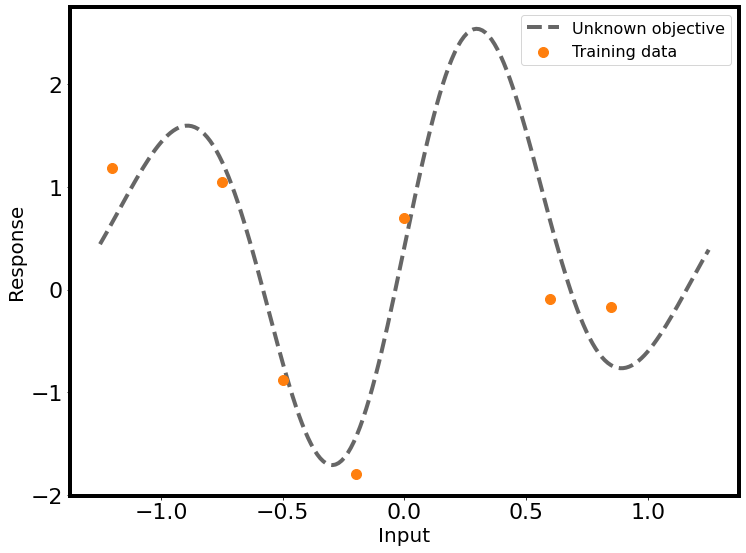

In [3]:
def f(x, noise):
    return ( .7*np.sin(5 * x) * (1 - .7*np.tanh(x ** 2)) + np.random.randn() * noise/100)

def generate_data(Xlist, noise=0.):
    Nsamples = len(Xlist)
    X = np.zeros([Nsamples, 1])
    Y = np.zeros(Nsamples)
    
    for i in range(Nsamples):
        X[i, :] = Xlist[i]
        # add some standard Gaussian noise to Y
        Y[i] = f(Xlist[i], noise)

    return np.vstack(X), np.vstack(Y)

# train data points
Xlist = [-1.2, -.75, -.5, -.2, 0., .6, .85]
X_train, Y_train = generate_data(Xlist, noise=10.)
X_test, Y_test = generate_data(list(np.linspace(-1.25, 1.25, 200)))

#Xscaler = StandardScaler().fit(X_train)
#X_train = Xscaler.transform(X_train)
#X_test  = Xscaler.transform(X_test)

Yscaler = StandardScaler().fit(np.vstack(Y_train))
Y_train = Yscaler.transform(np.vstack(Y_train))
Y_test  = Yscaler.transform(np.vstack(Y_test))

inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [4]:
n_inputs = X_train.shape[1]
n_hidden = 16
n_outputs = Y_train.shape[1]

ffnn = FFNN(n_inputs, n_hidden, n_outputs, alpha_0=1e-4)
print(f"Number of model parameters: {ffnn.n_params}")

Number of model parameters: 49


In [5]:
t0 = time.time()
ffnn.fit(X_train, Y_train, map_tol=1e-4)
print("Elapsed time: {:.3f} s".format(time.time()-t0))

Epoch: 0, Loss: 4.04002, Residuals: -0.41340, Convergence:   inf
Epoch: 10, Loss: 3.45265, Residuals: -0.36361, Convergence: 0.018726
Epoch: 20, Loss: 2.83380, Residuals: -0.33061, Convergence: 0.020153
Epoch: 30, Loss: 2.32035, Residuals: -0.29842, Convergence: 0.020203
Epoch: 40, Loss: 1.89980, Residuals: -0.26926, Convergence: 0.020190
Epoch: 50, Loss: 1.55586, Residuals: -0.24292, Convergence: 0.020155
Epoch: 60, Loss: 1.27474, Residuals: -0.21918, Convergence: 0.020104
Epoch: 70, Loss: 1.04504, Residuals: -0.19778, Convergence: 0.020035
Epoch: 80, Loss: 0.85741, Residuals: -0.17852, Convergence: 0.017103
Epoch: 90, Loss: 0.70413, Residuals: -0.16117, Convergence: 0.013971
Epoch: 100, Loss: 0.57890, Residuals: -0.14555, Convergence: 0.011416
Epoch: 110, Loss: 0.47655, Residuals: -0.13147, Convergence: 0.009330
Epoch: 120, Loss: 0.39289, Residuals: -0.11877, Convergence: 0.007628
Epoch: 130, Loss: 0.32449, Residuals: -0.10732, Convergence: 0.006237
Epoch: 140, Loss: 0.26857, Residua

Epoch: 1990, Loss: 0.79450, Residuals: -0.00731, Convergence: 0.000730
Epoch: 2000, Loss: 0.78684, Residuals: -0.00751, Convergence: 0.000790
Epoch: 2010, Loss: 0.77879, Residuals: -0.00771, Convergence: 0.000812
Epoch: 2020, Loss: 0.77068, Residuals: -0.00785, Convergence: 0.000807
Epoch: 2030, Loss: 0.76266, Residuals: -0.00790, Convergence: 0.000800
Epoch: 2040, Loss: 0.75452, Residuals: -0.00781, Convergence: 0.000840
Epoch: 2050, Loss: 0.74529, Residuals: -0.00754, Convergence: 0.001009
Epoch: 2060, Loss: 0.73410, Residuals: -0.00730, Convergence: 0.001195
Epoch: 2070, Loss: 0.72162, Residuals: -0.00719, Convergence: 0.001278
Epoch: 2080, Loss: 0.70868, Residuals: -0.00710, Convergence: 0.001300
Epoch: 2090, Loss: 0.69568, Residuals: -0.00696, Convergence: 0.001298
Epoch: 2100, Loss: 0.68276, Residuals: -0.00677, Convergence: 0.001286
Epoch: 2110, Loss: 0.66999, Residuals: -0.00655, Convergence: 0.001268
Epoch: 2120, Loss: 0.65741, Residuals: -0.00632, Convergence: 0.001249
Epoch:

In [6]:
Y, Y_stdv, COV = ffnn.predict(X_test)

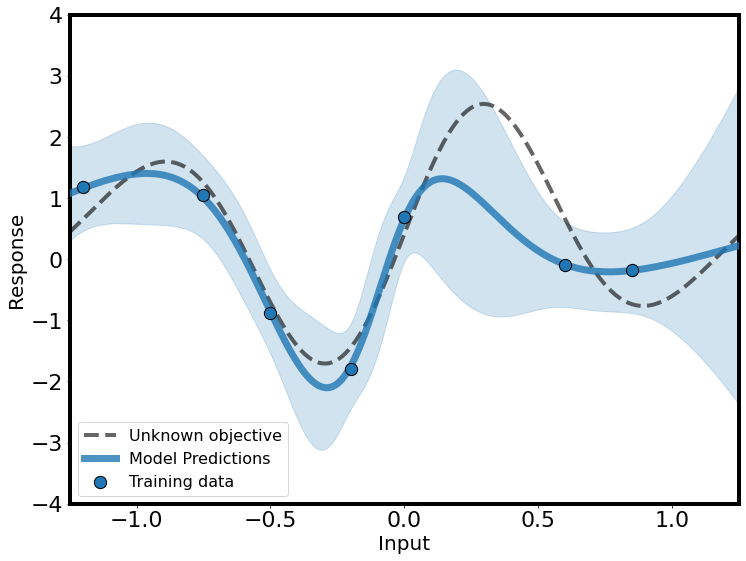

In [7]:
inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C0', edgecolor='k', s=150, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = .5 
plt.fill_between(X_test.ravel(), Y.ravel() - unc_factor*Y_stdv.ravel(), Y.ravel() + unc_factor*Y_stdv.ravel(), 
                 color='C0', alpha=0.2, zorder=1)
#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim([-4, 4])
plt.xlim([-1.25, 1.25])

plt.legend(fontsize=16, loc='lower left')
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig(f"Results/Parabola_0.pdf", dpi=300)
plt.show()

# Design next experiment

In [8]:
# define design space 
X_design, Y_design = generate_data(list(np.linspace(-1.2, 1.2, 200)))
#X_design = Xscaler.transform(X_design)
Y_design = Yscaler.transform(Y_design)

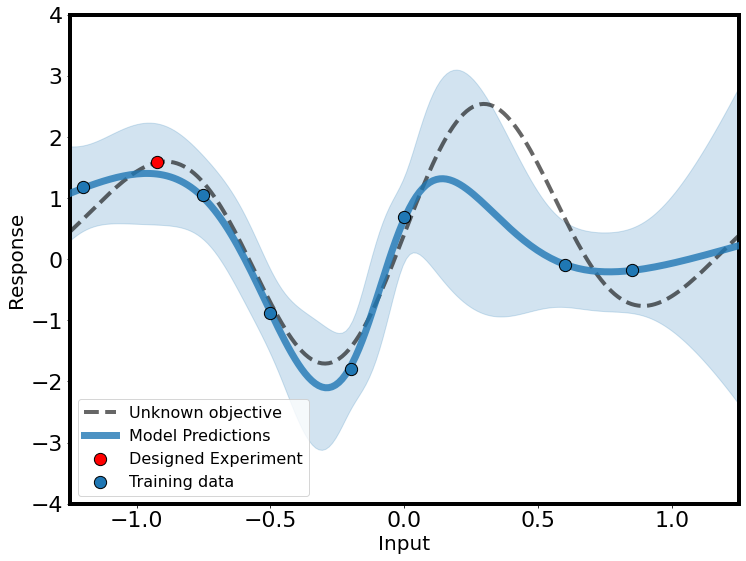

In [9]:
inds = np.argsort(np.ravel(X_train))

plt.scatter(X_design[np.argmax(Y.ravel())], Y_design[np.argmax(Y.ravel())].ravel(), c='r', edgecolor='k', s=150, label='Designed Experiment', zorder=4)

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C0', edgecolor='k', s=150, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = .5 
plt.fill_between(X_test.ravel(), Y.ravel() - unc_factor*Y_stdv.ravel(), Y.ravel() + unc_factor*Y_stdv.ravel(), 
                 color='C0', alpha=0.2, zorder=1)
#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim([-4, 4])
plt.xlim([-1.25, 1.25])

plt.legend(fontsize=16, loc='lower left')
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig(f"Results/Parabola_exploit.pdf", dpi=300)
plt.show()

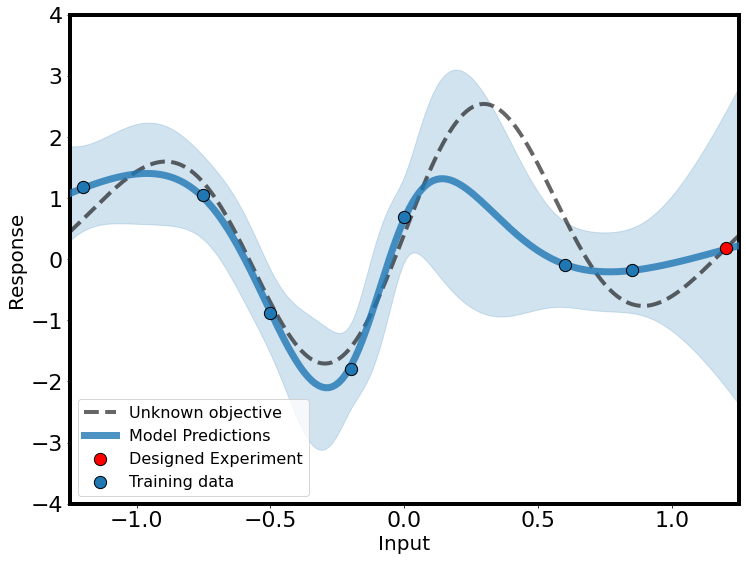

In [10]:
inds = np.argsort(np.ravel(X_train))

plt.scatter(X_design[np.argmax(Y_stdv.ravel())], Y_design[np.argmax(Y_stdv.ravel())].ravel(), c='r', edgecolor='k', s=150, label='Designed Experiment', zorder=4)

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C0', edgecolor='k', s=150, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = .5 
plt.fill_between(X_test.ravel(), Y.ravel() - unc_factor*Y_stdv.ravel(), Y.ravel() + unc_factor*Y_stdv.ravel(), 
                 color='C0', alpha=0.2, zorder=1)
#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim([-4, 4])
plt.xlim([-1.25, 1.25])

plt.legend(fontsize=16, loc='lower left')
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig(f"Results/Parabola_explore.pdf", dpi=300)
plt.show()

Top 5 utilities:  [[1.2911103]
 [1.2206343]
 [1.1511676]
 [1.0829837]
 [1.0160725]]
Picked experiment 0 out of 3
Top 5 utilities:  [[1.2346995]
 [1.1677222]
 [1.1018926]
 [1.0370431]
 [0.9735181]]
Picked experiment 1 out of 3
Top 5 utilities:  [[0.07246016]
 [0.06274126]
 [0.05442831]
 [0.04723473]
 [0.04124543]]
Picked experiment 2 out of 3


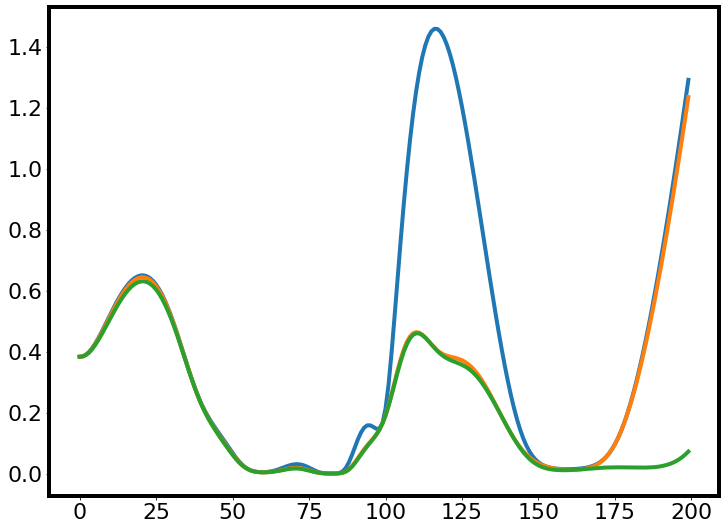

In [11]:
'''# define objective function
def objective(pred, stdv, explore):
    # return UCB 
    return pred + explore*stdv'''

'''fstar = np.max(Y_train)
def objective(pred, stdv):
    Z = (fstar - pred)/stdv
    return -cdf(Z)'''

fstar = np.max(Y_train)
def objective(pred, stdv):
    improvement = pred - fstar
    Z = improvement/stdv
    return improvement*cdf(Z) + stdv*pdf(Z)

design_inds = ffnn.searchEI(X_design, objective, 3)

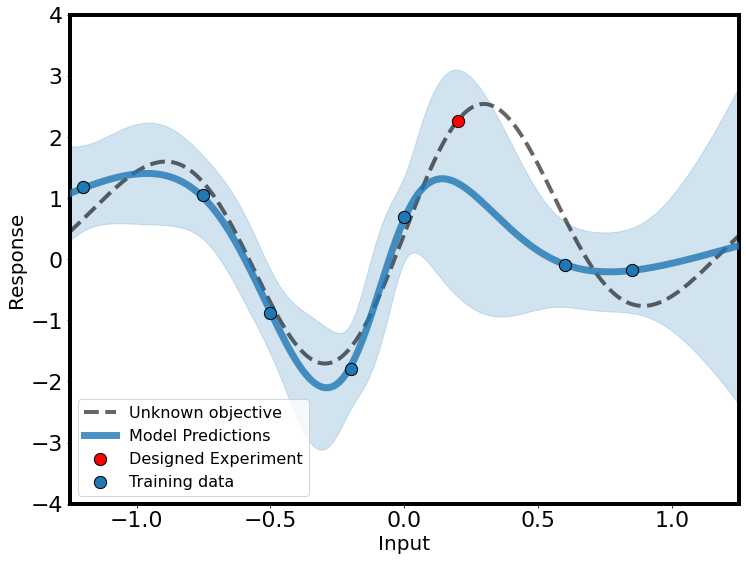

In [12]:
inds = np.argsort(np.ravel(X_train))

plt.scatter(X_design[design_inds[0]], Y_design[[design_inds[0]]].ravel(), c='r', edgecolor='k', s=150, label='Designed Experiment', zorder=4)

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C0', edgecolor='k', s=150, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = .5 
plt.fill_between(X_test.ravel(), Y.ravel() - unc_factor*Y_stdv.ravel(), Y.ravel() + unc_factor*Y_stdv.ravel(), 
                 color='C0', alpha=0.2, zorder=1)
#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim([-4, 4])
plt.xlim([-1.25, 1.25])

plt.legend(fontsize=16, loc='lower left')
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig(f"Results/Parabola_explore_exploit.pdf", dpi=300)
plt.show()

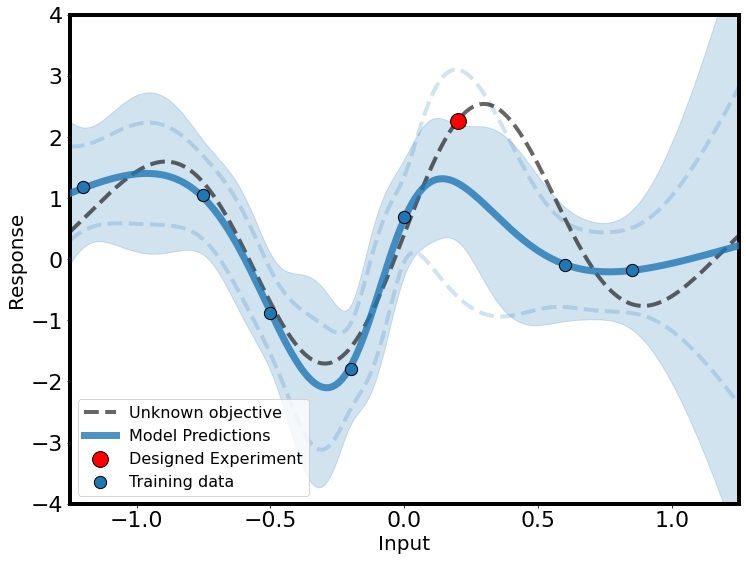

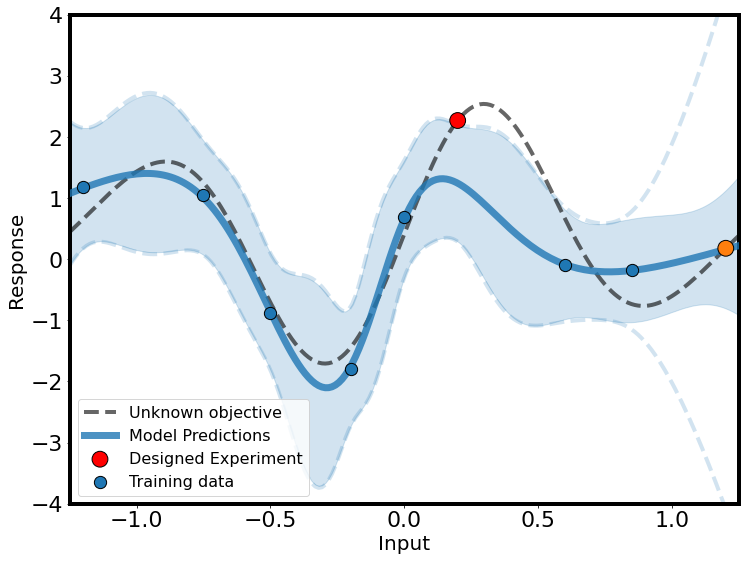

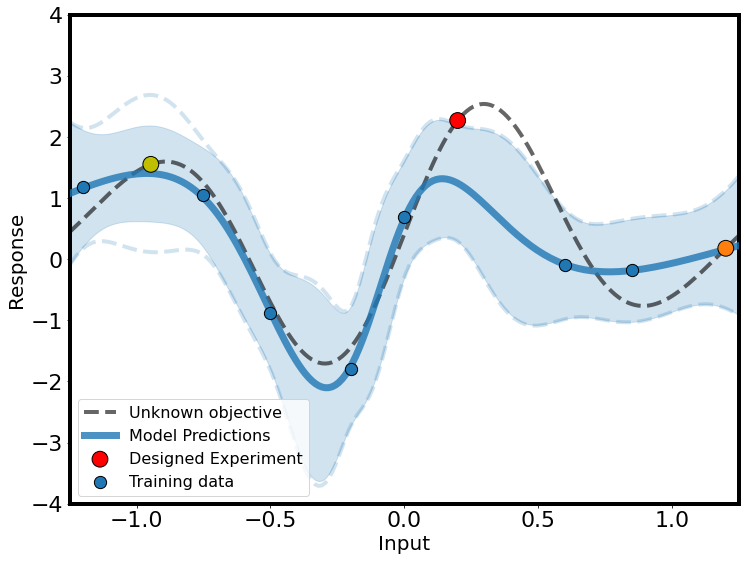

In [13]:
colors = ['r', 'C1', 'y']

for i in range(1,len(design_inds)+1):
    plt.plot(X_test.ravel(), Y.ravel() - unc_factor*Y_stdv.ravel(), linestyle='--',
                     color='C0', alpha=0.2, zorder=1)
    plt.plot(X_test.ravel(), Y.ravel() + unc_factor*Y_stdv.ravel(), linestyle='--',
                     color='C0', alpha=0.2, zorder=1)
    
    Y, Y_stdv, COV = ffnn.conditional_predict(X_test, X_design[design_inds[:i]])

    inds = np.argsort(np.ravel(X_train))

    # plot new design
    plt.scatter(X_design[design_inds[:i]].ravel(), Y_design[design_inds[:i]].ravel(), c=colors[:i], edgecolor='k', s=250, label='Designed Experiment', zorder=4)

    plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
    plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C0', s=150, edgecolor='k', label='Training data', zorder=4)

    plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
    unc_factor = 1. 
    plt.fill_between(X_test.ravel(), Y.ravel() - unc_factor*Y_stdv.ravel(), Y.ravel() + unc_factor*Y_stdv.ravel(), 
                     color='C0', alpha=0.2, zorder=1)
    #plt.title("Maximum A Posteriori")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([-4, 4])
    plt.xlim([-1.25, 1.25])
    
    plt.legend(fontsize=16, loc='lower left')
    plt.xlabel("Input")
    plt.ylabel("Response")
    plt.savefig(f"Results/Parabola_{i}.pdf", dpi=300)
    plt.show()